In [1]:
# This example runs single recording sorting using local computer
# Created by James Jun on Feb 26, 2019

# prerequisits
# $ pip install ml_ms4alg
# $ conda install -c conda-forge ipywidgets
# $ jupyter labextension install @jupyter-widgets/jupyterlab-manager

# please ignore the warning when running MountainSort4
#   RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import spikeforest_analysis as sa
from spikeforest import spikeextractors as se
import os
import shutil
import sfdata as sf
import numpy as np
from spikesorters import IronClust, MountainSort4, KiloSort, KiloSort2
from spikeforest import spiketoolkit as st
from spikeforest import spikewidgets as sw
import ipywidgets as widgets

In [83]:
# select a data source and sorter
# you may change the data source index and sorter index
v_sorter = ['IronClust', 'IronClust_drift', 'MountainSort4', 'KiloSort', 'KiloSort2']
widget1 = widgets.Dropdown(
    options=v_sorter, 
    index=0, description='Spike sorters')
display(widget1)

v_datasource = ['generate locally', 'download']
widget2 = widgets.Dropdown(
    options=v_datasource, 
    index=0, description='Data source')
display(widget2)

Dropdown(description='Spike sorters', options=('IronClust', 'IronClust_drift', 'MountainSort4', 'KiloSort', 'K…

Dropdown(description='Data source', options=('generate locally', 'download'), value='generate locally')

In [116]:
# create a parameters dictionary
params = dict(
    sorter = v_sorter[widget1.index],
    datasource = v_datasource[widget2.index],
    in_path = 'recordings/example1',
    out_path = os.path.join('sortings/example1', v_sorter[widget1.index])
    )

In [117]:
# get recording
recpath = params['in_path']
# delete previous recording
#  os.path.exists(recpath): shutil.rmtree(recpath)

# delete previous output and make save
recpath_true = os.path.join(recpath, 'firings_true.mda')

if params['datasource'] == 'generate locally':
    print(recpath_true)
    if not os.path.exists(recpath_true):
        # generate recording
        rx, sx_true = se.example_datasets.toy_example1(
            duration=600, num_channels=4, samplerate=30000, K=10)
        print('Generated recording in ' + recpath)
    else:
        rx = se.MdaRecordingExtractor(recpath)
        sx_true = se.MdaSortingExtractor(recpath_true)
        print('Using cached recording in ' + recpath)
else:
    # download recording
    #kpath = 'kbucket://15734439d8cf/groundtruth/magland_synth/datasets_noise10_K10_C4/001_synth'
    #kpath = '/mnt/home/jjun/ceph/groundtruth/hybrid_drift/rec_32c_600s_11'
    kpath = '/mnt/home/jjun/ceph/groundtruth/hybrid_drift/rec_64c_1200s_11'
    rx = se.MdaRecordingExtractor(kpath, download=True)
    sx_true = se.MdaSortingExtractor(kpath + '/firings_true.mda')   
    
if not os.path.exists(recpath): 
    os.makedirs(recpath)
    se.MdaRecordingExtractor.writeRecording(recording=rx, save_path=recpath)
    se.MdaSortingExtractor.writeSorting(
        sorting=sx_true, save_path=recpath_true)
        

In [118]:
# Define sorters

def irc(recpath, firings_out):
    return IronClust.execute(
            recording_dir=recpath,
            firings_out=firings_out,
            detect_sign=-1,
            adjacency_radius=100,
            prm_template_name='static',
            _force_run=False)

def irc_drift(recpath, firings_out):
    return IronClust.execute(
            recording_dir=recpath,
            firings_out=firings_out,
            detect_sign=-1,
            adjacency_radius=100,
            prm_template_name='drift',
            _force_run=False)

def ms4(recpath, firings_out):
    return MountainSort4.execute(
            recording_dir=recpath,
            firings_out=firings_out,
            detect_sign=-1,
            adjacency_radius=100,
            _force_run=False)

def ksort(recpath, firings_out):
    return KiloSort.execute(
            recording_dir=recpath,
            firings_out=firings_out,
            detect_sign=-1,
            adjacency_radius=100,
            _force_run=False)

def ksort2(recpath, firings_out):
    return KiloSort.execute(
            recording_dir=recpath,
            firings_out=firings_out,
            detect_sign=-1,
            adjacency_radius=100,
            _force_run=False)

v_sorters = dict(KiloSort=ksort, IronClust=irc, MountainSort4=ms4, KiloSort2=ksort2, IronClust_drift=irc_drift)

In [119]:
# Run spike sorting. ignore numpy.ufunc w on MountainSort4
savepath = params['out_path']
firings_out = os.path.join(savepath, 'firings_out.mda')
if not os.path.exists(savepath): 
    os.makedirs(savepath)   
if not os.path.exists(firings_out):
    print('Running '+params['sorter'] + ' in notebook.')
    v_sorters[params['sorter']](
        recpath, 
        firings_out)    
    sx = se.MdaSortingExtractor(firings_out)
else:
    print('Loaded '+params['sorter'] + ' from ' + savepath)
    sx = se.MdaSortingExtractor(firings_out)

Loaded KiloSort2 from sortings/example1/KiloSort2


In [120]:
# Run validation and display

comparison=st.comparison.SortingComparison(
    sorting1=sx_true, sorting1_name='true',
    sorting2=sx, sorting2_name=params['sorter'],
    )
#comparison_table = sw.SortingComparisonTable(comparison=comparison)

#print('sorting output for {}:'.format(params['sorter']))
# comparison_table.display()

# compute SNR of the ground truth units

path_json_out = os.path.join(params['out_path'], 'summary_true.mda')
sa.compute_units_info.ComputeUnitsInfo.execute(
    recording_dir = params['in_path'],
    firings = os.path.join(params['in_path'], 'firings_true.mda'),
    json_out = path_json_out,
    _force_run = False
    )

import json
with open(path_json_out) as f:
    snr_json = json.load(f)
unit_snrs = [x['snr'] for x in snr_json]
unit_ids = [x['unit_id'] for x in snr_json]
sx_true.setUnitsProperty(property_name='snr', 
                         values=unit_snrs, unit_ids=unit_ids)

# plot SNR vs accuracy for the first sorting output
a=sw.SortingAccuracyWidget(
    sorting_comparison=comparison,
    property_name='snr');

Creating job 


Sorter: IronClust


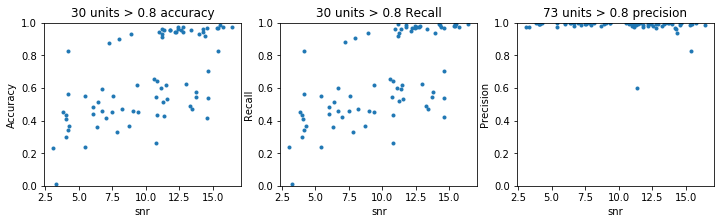

In [93]:
print('Sorter: ' + params['sorter'])
a.plot(mode='all')

Sorter: KiloSort2


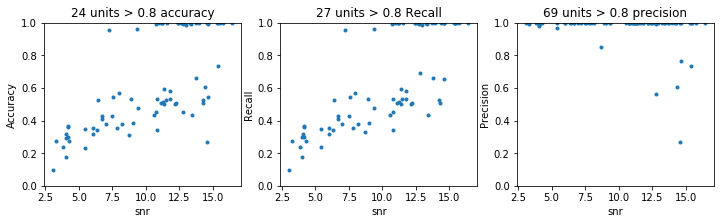

In [121]:
print('Sorter: ' + params['sorter'])
a.plot(mode='all')

Sorter: KiloSort


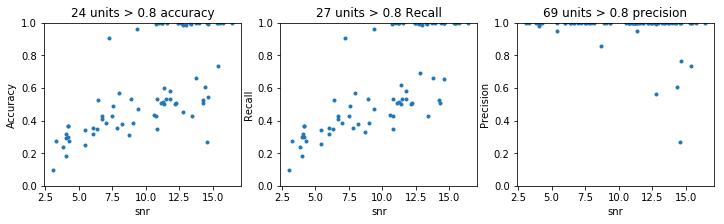

In [115]:
print('Sorter: ' + params['sorter'])
a.plot(mode='all')

Sorter: MountainSort4


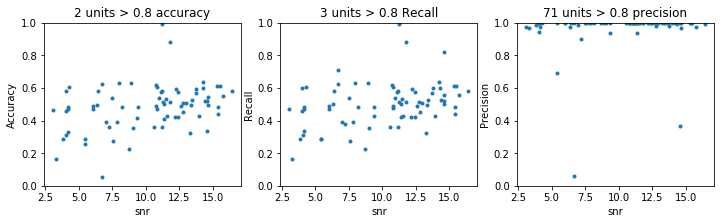

In [109]:
print('Sorter: ' + params['sorter'])
a.plot(mode='all')